In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def evaluate_polynomial(poly, x):
    
    """ evaluate polynomial value at a given point x
        poly - List containing polynomial coefficients, highest order on the left, 
                last item on the list is the free coefficient
    """
    _sum = 0
    
    order = len(poly) - 1
    
    # create a new list, every item in this list is mekadem*(x**order). then sum the list
    _sum = sum([m*(x**i) for m,i in zip(poly, range(order,-1,-1))])
    
    return _sum

In [3]:
def evaluate_derivative(poly, x):
    
    """ evaluate the derivative of a polynomial at a given point x
    """
    # find a near point to x, so the difference between them is infinitesimal (0.0001)
    x1 = x - 0.0001
    
    # evaluate the value of the polynomial at both points x and x1
    fx = evaluate_polynomial(poly, x)
    fx1 = evaluate_polynomial(poly, x1)
    
    # calculate derivative as usual
    derivative = (fx - fx1)/(x - x1)
    return derivative

In [4]:
def polynomial_division(poly, divisor):
    
    """ poly - polynomial to be divided
        divisor - polynomial to divide by
    """
    # new_poly is the result polynomial of the division
    new_poly = []
    
    while len(poly) >= len(divisor):
        # divide the highest order coefficients from poly and divisor to find a coefficient for new_poly
        mekadem = poly[0]/divisor[0]
        new_poly.append(mekadem)
        
        # multiply the divisor by the coefficient we found in the previous step, to get the polynomial to subtract from poly
        subtract_poly = [mekadem*m for m in divisor]
        
        # if subtract poly order is less than poly order, add 0's at the end of subtract poly. 
        # this is to ensure both lists have the same length so we can subtract the two polynomials
        order_diff = len(poly) - len(subtract_poly)
        for i in range(0, order_diff):
            subtract_poly.append(0)
            
        # calculate the new poly from after subtraction
        poly = [a-b for a,b in zip(poly, subtract_poly)]
        
        # if the coefficients of the on the left are zero, remove them from the list
        poly = np.trim_zeros(poly,"f")
    
    # remainder is the polynom that remains when the order of poly is less than the order of divisor
    remainder = ([0] if poly==[] else poly)
    
    return new_poly, remainder

In [5]:
def bisection_find_root(poly, limits, epsilon, i=1, max_i=4):
    
    """ poly - polynomial of interest
        limits - a tuple of lower limit and upper limit. Assumption: the limits are NOT roots. Example: (-3,5)
        epsilon - Order of precision. Examples: 10**-4, 10**-1
        i - iteration number
        max_i - maximal number of iterations allowed
    """
    llim, ulim = limits
    mid_point = (llim + ulim)/2
    
    # if reached maximal number of iterations return mid point
    if i>max_i:
        return mid_point
    
    # if the segment is smaller than epsilon, return its mid point
    if abs(ulim-llim) < epsilon:
        return mid_point
    
    # evaluate polynomial at mid point, if its smaller than epsilon return mid point
    poly_value_mid_point = evaluate_polynomial(poly, mid_point)
    if np.abs(poly_value_mid_point) <= epsilon:
        return mid_point
    
    # evaluate polynomial at lower limit
    poly_value_llim = evaluate_polynomial(poly, llim)
    
    # check if there is a root in the segment between lower limit and mid point. 
    # If true define this segment as the new segment and repeat bisection for this segment
    if poly_value_llim*poly_value_mid_point < 0:
        limits = (llim, mid_point)
    # else repeat bisection for segment between mid point and upper limit
    else:
        limits = (mid_point, ulim)
    
    return bisection_find_root(poly, limits, epsilon, i=i+1)

In [12]:
def newton_raphson(poly, x_guess, epsilon, i=1):
    
    """ 
    """
    # evaluate polynomial at x_guess
    poly_value_x_guess = evaluate_polynomial(poly, x_guess)
    
    # if polynomial value at x_guess is close enough to zero, return it
    if np.abs(poly_value_x_guess) <= epsilon:
        return x_guess
    
    # evaluate derivative and use it in Newton Raphson formula to calculate a new guess
    poly_derivative_x_guess = evaluate_derivative(poly, x_guess)
    
    # make sure derivative is not zero before calculating next iteration
    if poly_derivative_x_guess != 0:
        x_new_guess = x_guess - (poly_value_x_guess/poly_derivative_x_guess)
    else:
        return x_guess
    return newton_raphson(poly, x_new_guess, epsilon, i=i+1)

In [7]:
def synthetic_divison(poly, x_guess, epsilon, i=1):
    
    """
    """
    divisor = [1, -x_guess]
    
    # calculate the remainders
    poly0, remainder0 = polynomial_division(poly, divisor)
    poly1, remainder1 = polynomial_division(poly0, divisor)
    R0 = remainder0[0]
    R1 = remainder1[0]
    
    # calculate the next x, with synthetic division formula
    if R1 != 0:
        x_new_guess = x_guess - (R0/R1)
    else:
        x_new_guess = x_guess
    
    # if there is a convergence return x_new_guess
    if np.abs(x_new_guess - x_guess) < epsilon:
        return x_new_guess
    
    # if no convergence, calculate another iteration
    return synthetic_divison(poly,x_new_guess, epsilon, i=i+1)

In [8]:
def find_roots(poly, method):
    
    """ a wrapper function, gets a method, either newton_raphson or synthetic_divison.
    """
    # find to polynomial order to know how many roots (iterations) we have
    poly_order = len(poly)-1
    
    # all the roots we will find, will be appended to this list
    roots = []
    
    # get the first guess with bisection method
    guess = bisection_find_root(poly, limits=(-3,5), epsilon=epsilon)

    for i in range(poly_order):
        # calculate a root and append it to list of roots
        root = method(poly, guess, epsilon=epsilon)
        roots.append(root)
        
        # diminish polynomial order, by dividing it by a polynomial based on the root found
        divisor = [1, -root]
        poly, _ = polynomial_division(poly,divisor)
    
    roots.sort()
    print(f"* Roots of the polynomial, calculated with {method.__name__}:")    
    print(f"\n\t{roots}\n\n")
    print("-"*100)
    
    return roots

In [9]:
def check_precision(numeric_roots, analytic_roots, method_name=None):
    
    """ make sure every root is within the precision limit of 10**-4
    """
    # if method_name provided
    if method_name:
        method_name = method_name
    else:
        method_name = "YOUR METHOD"
        
    if all([a-b < epsilon for a,b in zip(numeric_roots, analytic_roots)]):
        print(f"* All the roots calculated with {method_name} are within the limit of\
            \n\t{epsilon} precision with respect to the Numpy roots\n")
    else:
        print(f"* At least one of the roots calculated with {method_name} is not within the precision limit!\n")
    print("-"*100)

In [29]:
def plot_polynomial(poly, limits, png_name=None):
    
    """
    """
    llim, ulim = limits
    x = np.linspace(llim, ulim, 1000)

    f = evaluate_polynomial(poly, x)

    ax = plt.figure(figsize=(16,9))
    plt.plot(x, f)
    ax.axes[0].axhline(linewidth=1.5, color='black')
    ax.axes[0].axvline(linewidth=1.5, color='black')

    plt.grid()
    
    if png_name:
        plt.savefig(f"{png_name}.png", bbox_inches="tight")
    else:
        plt.show()

In [14]:
while True:
    
    poly = input("\tEnter polynomial in a form of a list. For example [1,2,-7,0,3]\n\tOr type '#' to exit\n\n\t")
    
    if poly == "#":
        print("-"*100)
        print("\tThank you, come again!")
        break
    
    poly = [int(x) for x in poly.strip("[]").split(",")]
    epsilon = 10**-4


    # calculate roots with Newton Raphson
    nr_roots = find_roots(poly, newton_raphson)


    # calculate roots with synthetic division
    sd_roots = find_roots(poly, synthetic_divison)


    # show the roots calculated with numpy
    np_poly = np.poly1d(poly)
    np_roots = np_poly.roots
    # sort the numbers for highest to lowest
    np_roots.sort()
    print("* Roots calculated with numpy:")
    print(f"\n\t{np_roots}\n")
    print("-"*100)


    # check precision for Newton Raphson against numpy roots
    check_precision(nr_roots, np_roots, method_name="Newton Raphson")

    # check precision for synthetic division against numpy roots
    check_precision(sd_roots, np_roots, method_name="synthetic division")

	Enter polynomial in a form of a list. For example [1,2,-7,0,3]
	Or type '#' to exit

	[1,2,-7,0,3]
* Roots of the polynomial, calculated with newton_raphson:

	[-3.7912918438096934, -0.6180286854312288, 0.7912850447974852, 1.6180354844311333]


----------------------------------------------------------------------------------------------------
* Roots of the polynomial, calculated with synthetic_divison:

	[-3.7912878473186793, -0.6180339892755388, 0.7912878478390712, 1.6180339887551471]


----------------------------------------------------------------------------------------------------
* Roots calculated with numpy:

	[-3.79128785 -0.61803399  0.79128785  1.61803399]

----------------------------------------------------------------------------------------------------
* All the roots calculated with Newton Raphson are within the limit of            
	0.0001 precision with respect to the Numpy roots

------------------------------------------------------------------------------------

In [38]:
poly = [1,2,-7,0,3]

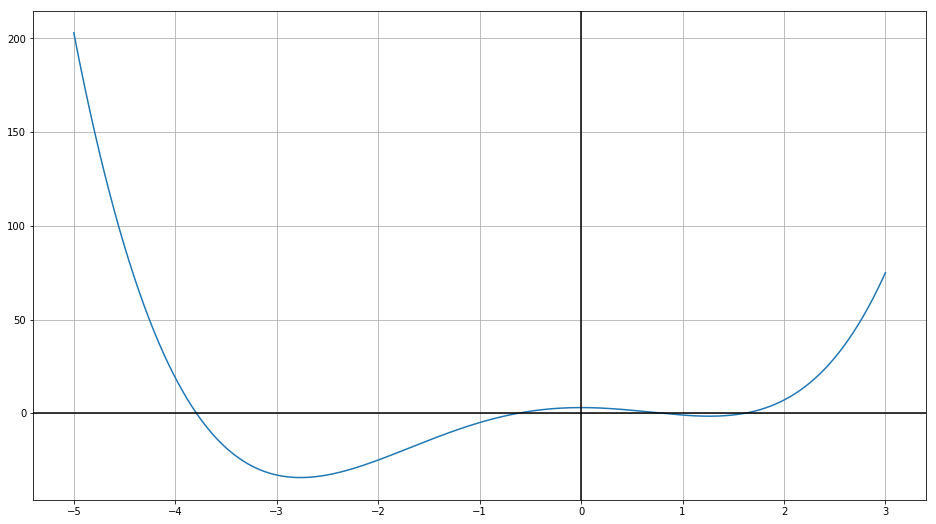

In [39]:
plot_polynomial(poly,(-5,3))

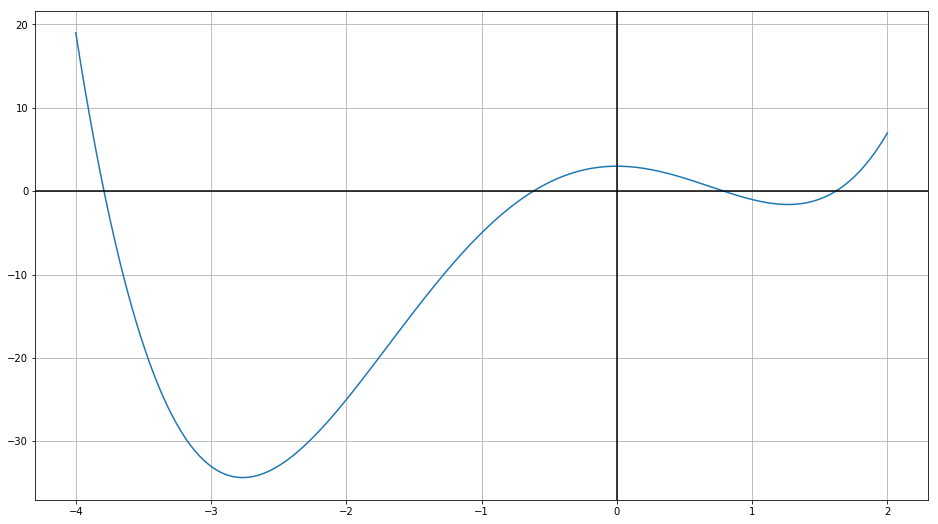

In [40]:
plot_polynomial(poly,(-4,2))